# SMS Spam Detection

Import Modules

In [1]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from nltk.corpus import words
from tqdm.notebook import tqdm

Read the dataset into a Pandas DataFrame

In [2]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.drop_duplicates()
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Exploratory Data Analysis

In [3]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


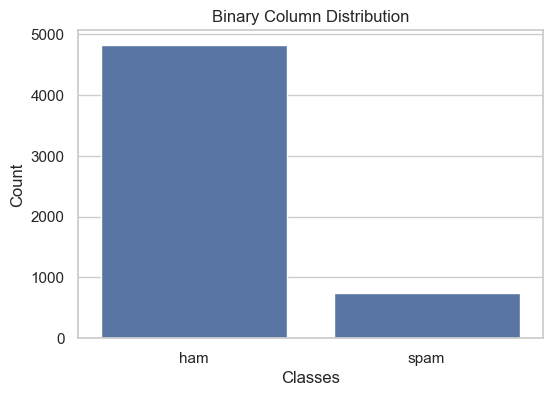

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'binary_column' is the name of your binary column
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

ax = sns.countplot(x = "label", data=df)

# Add labels and title
ax.set_xlabel("Classes")
ax.set_ylabel("Count")
ax.set_title("Label Distribution")

# Show the plot
plt.show()

Feature Engineering

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

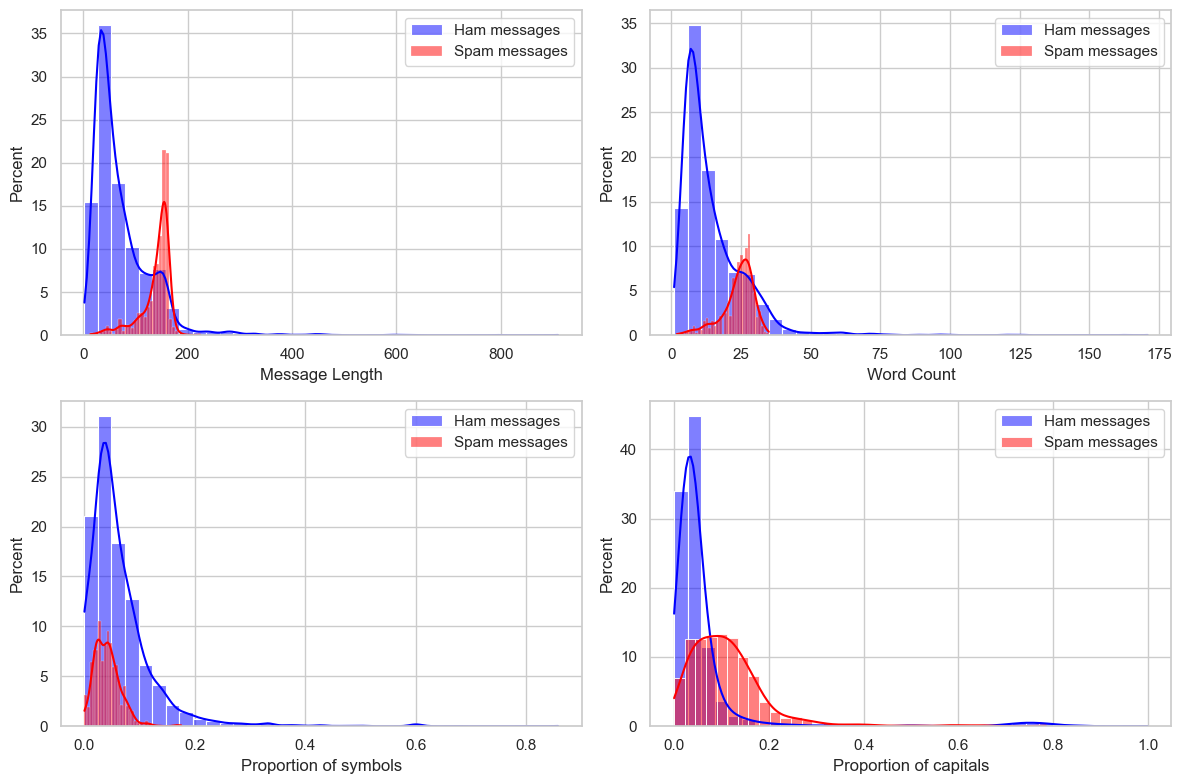

In [5]:
def count_words(text):
    return len(text.split(" "))

def count_symbols(message):
    symbols = set(string.punctuation)
    count = sum(1 for char in message if char in symbols)
    return count / len(message)


def count_capitals(message):
    count = sum(1 for char in message if char.isupper())
    return count / len(message)

# Label into binary column
df["label"] = df["label"].map({"ham": 0, "spam": 1})

# Create new features 
tqdm.pandas(desc='My bar!')
df["length"] = df["message"].progress_apply(len)

tqdm.pandas(desc='My bar!')
df["word_count"] = df["message"].progress_apply(count_words)

tqdm.pandas(desc='My bar!')
df["symbols"] = df["message"].progress_apply(count_symbols)

tqdm.pandas(desc='My bar!')
df["capitals"] = df["message"].progress_apply(count_capitals)


plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["length"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["length"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")
plt.legend()
plt.xlabel("Message Length")

# Plot 2: Word Count
plt.subplot(2, 2, 2)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["word_count"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["word_count"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")
plt.legend()
plt.xlabel("Word Count")

# Plot 3: Proportion of Symbols
plt.subplot(2, 2, 3)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["symbols"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["symbols"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")
plt.legend()
plt.xlabel("Proportion of symbols")

# Plot 4: Proportion of Capitals
plt.subplot(2, 2, 4)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["capitals"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["capitals"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")
plt.legend()
plt.xlabel("Proportion of capitals")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Testing if spam and ham are distributed differently for each feature

In [6]:
features = [i for i in df.columns if i not in ["label", "message"]]
for feature in features:
    ks_statistic, p_value = ks_2samp(ham_data[feature], spam_data[feature])
    print(f"Kolmogorov-Smirnov Statistic for {feature}:", ks_statistic)
    print("P-Value:", p_value)
    alpha = 0.05  # Set your significance level
    if p_value < alpha:
        print("The distributions are significantly different.")
    else:
        print("The distributions are not significantly different.")
    print("--------------------------------------------")

Kolmogorov-Smirnov Statistic for length: 0.6784415728544576
P-Value: 8.17299035435783e-290
The distributions are significantly different.
--------------------------------------------
Kolmogorov-Smirnov Statistic for word_count: 0.594013220411872
P-Value: 1.6806655583102593e-215
The distributions are significantly different.
--------------------------------------------
Kolmogorov-Smirnov Statistic for symbols: 0.21631201836707797
P-Value: 5.046492269780785e-27
The distributions are significantly different.
--------------------------------------------
Kolmogorov-Smirnov Statistic for capitals: 0.5352696450742521
P-Value: 4.415291113781373e-172
The distributions are significantly different.
--------------------------------------------


Text pre-processing

In [7]:
def process_text(message):
    message = "".join([char for char in message if char not in string.punctuation]).lower()
    STOPWORDS  = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    return ' '.join([word for word in message.split() if word not in STOPWORDS])
df["message"] = df["message"].apply(process_text)
df

,label,message,length,word_count,symbols,capitals
0,0,go jurong point crazy available bugis n great ...,111,20,0.081081,0.027027
1,0,ok lar joking wif oni,29,6,0.206897,0.068966
2,1,free entry wkly comp win fa cup final tkts 21s...,155,28,0.038710,0.064516
3,0,dun say early hor c already say,49,11,0.122449,0.040816
4,0,nah think goes usf lives around though,61,13,0.032787,0.032787
...,...,...,...,...,...,...
5567,1,2nd time tried contact å£750 pound prize claim...,161,30,0.049689,0.055901
5568,0,ì b going esplanade fr home,37,8,0.054054,0.054054
5569,0,pity mood soany suggestions,57,10,0.122807,0.035088
5570,0,guy bitching acted like id interested buying s...,125,26,0.008000,0.016000


More feature engineering after pre-processed data

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

Kolmogorov-Smirnov Statistic: 0.47308043920067144
P-Value: 1.7254777089544667e-132
The distributions are significantly different.


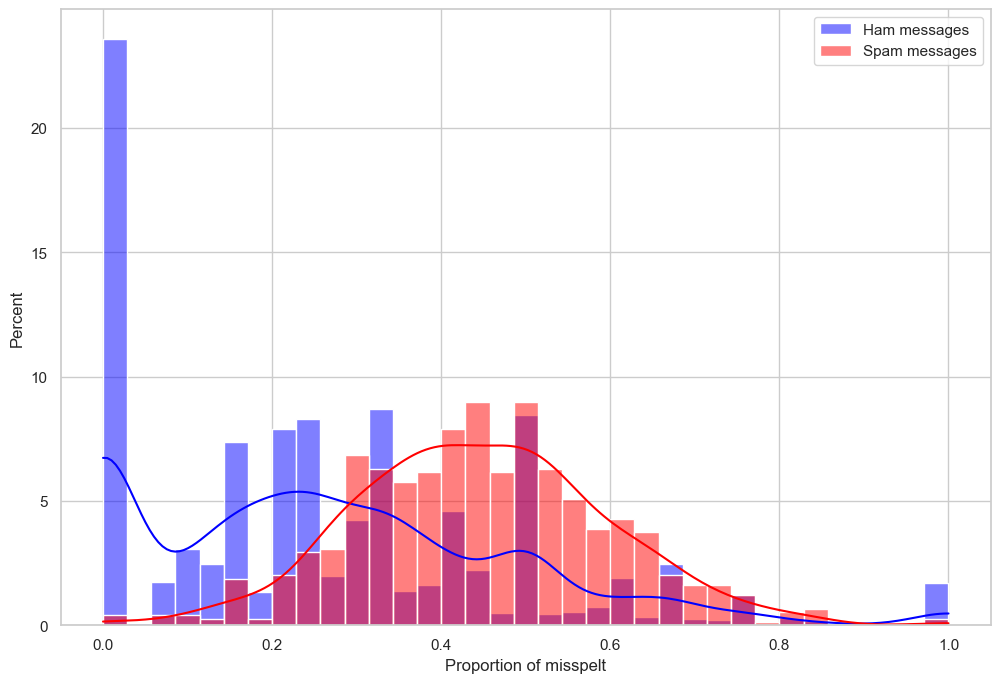

In [8]:
def freq_incorrect(text):
    WORDS = text.split(" ")
    english_vocab = set(w.lower() for w in words.words())
    misspelled = len([word for word in WORDS if word not in english_vocab])
    return misspelled / len(WORDS)

if "misspelt" not in df.columns:
    tqdm.pandas(desc='My bar!')
    df["misspelt"] = df["message"].progress_apply(freq_incorrect)

ham_data = df[df["label"] == 0]
spam_data = df[df["label"] == 1]
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["misspelt"], spam_data["misspelt"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
sns.histplot(ham_data["misspelt"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
sns.histplot(spam_data["misspelt"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Proportion of misspelt")
plt.show()

Reducing the size of the vocabulary by stemming

In [9]:
from nltk.stem.porter import PorterStemmer

def stemming(text):
    port_stem = PorterStemmer()
    text = [port_stem.stem(word) for word in text.split(" ") if word not in stopwords.words('english')]
    return " ".join(text)

tqdm.pandas(desc='My bar!')
df["message"] = df["message"].progress_apply(stemming)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,word_count,symbols,capitals,misspelt
0,0,go jurong point crazi avail bugi n great world...,111,20,0.081081,0.027027,0.187500
1,0,ok lar joke wif oni,29,6,0.206897,0.068966,0.600000
2,1,free entri wkli comp win fa cup final tkt 21st...,155,28,0.038710,0.064516,0.454545
3,0,dun say earli hor c alreadi say,49,11,0.122449,0.040816,0.142857
4,0,nah think goe usf live around though,61,13,0.032787,0.032787,0.428571
...,...,...,...,...,...,...,...
5567,1,2nd time tri contact å£750 pound prize claim e...,161,30,0.049689,0.055901,0.375000
5568,0,ì b go esplanad fr home,37,8,0.054054,0.054054,0.333333
5569,0,piti mood soani suggest,57,10,0.122807,0.035088,0.500000
5570,0,guy bitch act like id interest buy someth els ...,125,26,0.008000,0.016000,0.214286


Adding a sentiment feature

In [10]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
def sentiment_label(text, sentiment_pipeline):
    label = sentiment_pipeline(text)[0]["label"]
    if label == "POSITIVE":
        return 0
    else:
        return 1

tqdm.pandas(desc='My bar!')
df["sentiment_label"] = df["message"].progress_apply(lambda x: sentiment_label(x, sentiment_pipeline=sentiment_pipeline))
df

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,word_count,symbols,capitals,misspelt,sentiment_label
0,0,go jurong point crazi avail bugi n great world...,111,20,0.081081,0.027027,0.187500,1
1,0,ok lar joke wif oni,29,6,0.206897,0.068966,0.600000,1
2,1,free entri wkli comp win fa cup final tkt 21st...,155,28,0.038710,0.064516,0.454545,1
3,0,dun say earli hor c alreadi say,49,11,0.122449,0.040816,0.142857,1
4,0,nah think goe usf live around though,61,13,0.032787,0.032787,0.428571,1
...,...,...,...,...,...,...,...,...
5567,1,2nd time tri contact å£750 pound prize claim e...,161,30,0.049689,0.055901,0.375000,1
5568,0,ì b go esplanad fr home,37,8,0.054054,0.054054,0.333333,0
5569,0,piti mood soani suggest,57,10,0.122807,0.035088,0.500000,1
5570,0,guy bitch act like id interest buy someth els ...,125,26,0.008000,0.016000,0.214286,1


We observe that sentiment labels are distributed differently across the spam and label labels and attests to spam messages typically being negative. Thus, we will use this reasoning as a basis for incorporating this feature into our model.

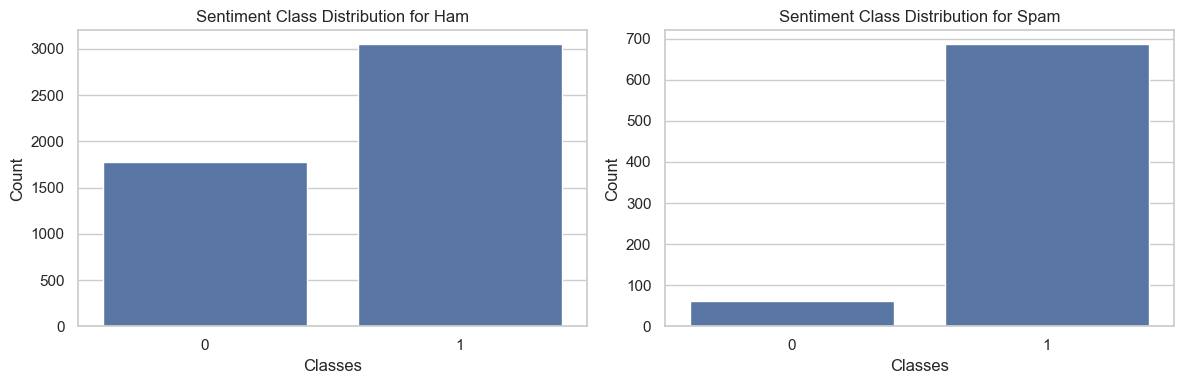

In [12]:
# Set the style
sns.set(style="whitegrid")

# Create a 1x2 subplot layout
plt.figure(figsize=(12, 4))

# Plot for Ham
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x="sentiment_label", data=df[df["label"] == 0])
ax1.set_xlabel("Classes")
ax1.set_ylabel("Count")
ax1.set_title("Sentiment Class Distribution for Ham")

# Plot for Spam
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x="sentiment_label", data=df[df["label"] == 1])
ax2.set_xlabel("Classes")
ax2.set_ylabel("Count")
ax2.set_title("Sentiment Class Distribution for Spam")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Intermediate tokenisation used for word frequency and visualisation purposes to see the results of our pre-processing

In [13]:
from nltk.tokenize import word_tokenize

df['tokens'] = df['message'].apply(word_tokenize)

Numeric representation of word frequencies in descending order

In [14]:
from itertools import chain
from collections import Counter

vocab_list = list(chain(*df["tokens"].tolist()))
counter = Counter(vocab_list)
counter

Counter({'call': 653,
         'go': 449,
         'get': 447,
         'come': 297,
         'ok': 277,
         'ltgt': 276,
         'free': 275,
         'know': 270,
         'like': 255,
         'got': 250,
         'love': 244,
         'want': 243,
         'day': 241,
         'ill': 239,
         'time': 238,
         'good': 235,
         'text': 224,
         'send': 204,
         'need': 186,
         'one': 180,
         'txt': 176,
         'see': 171,
         'today': 169,
         'think': 166,
         'home': 162,
         'take': 160,
         'lor': 160,
         'repli': 159,
         'stop': 158,
         'tell': 156,
         'sorri': 156,
         'still': 153,
         'r': 153,
         'back': 152,
         'mobil': 150,
         'make': 147,
         'n': 143,
         'phone': 141,
         'say': 138,
         'new': 136,
         'week': 134,
         'work': 134,
         'pleas': 134,
         'later': 134,
         'well': 133,
         'da': 132,
 

Graphical visualisation of word frequencies in the data. In some preprocessing techniques, I observed that words under a threshold length were removed. However, I believed that text messages tend to be informal whether it be spam or ham and abbreviations or shortened words can capture informative results.

<function matplotlib.pyplot.show(close=None, block=None)>

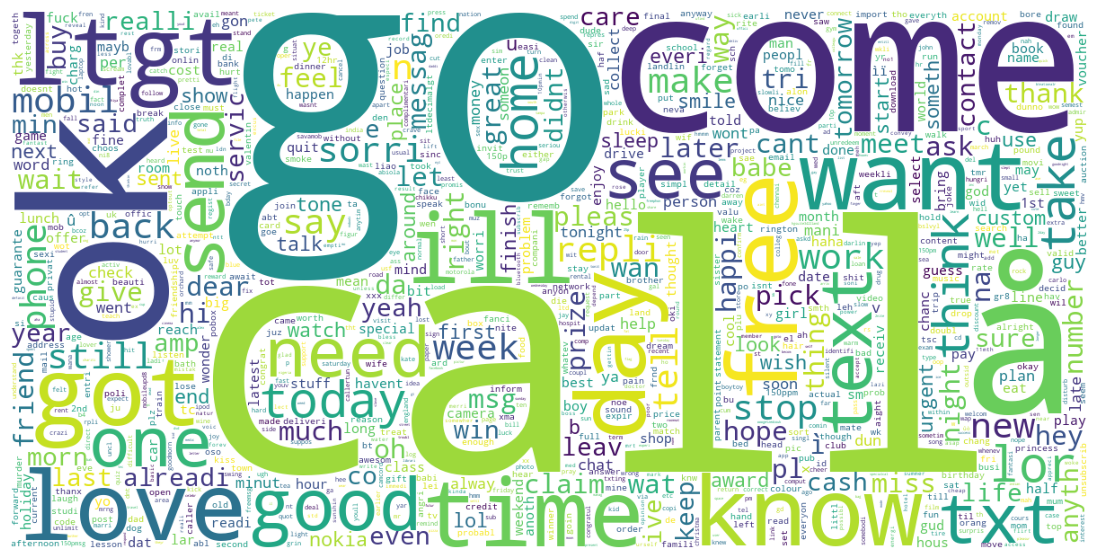

In [15]:
from wordcloud import WordCloud

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)
wc.generate(' '.join(vocab_list))

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

Now that we have extracted all our features. We standardise them to ensure features are equally treated.

In [49]:
from sklearn.preprocessing import StandardScaler

columns_to_standardize = [i for i in df.columns if i not in ["label", "message", "sentiment_label", "tokens"]]
scaler = StandardScaler()

# Fit and transform the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
df.to_csv('cleaned_sms.csv', index=False)
df

,label,message,length,word_count,symbols,capitals,misspelt,sentiment_label,tokens
0,0,go jurong point crazi avail bugi n great world...,0.517399,0.384646,0.363322,-0.360707,-0.448692,1,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,ok lar joke wif oni,-0.856470,-0.841118,2.511001,0.023752,1.392761,1,"[ok, lar, joke, wif, oni]"
2,1,free entri wkli comp win fa cup final tkt 21st...,1.254596,1.085083,-0.359960,-0.017036,0.743433,1,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,0,dun say earli hor c alreadi say,-0.521380,-0.403345,1.069475,-0.234298,-0.647983,1,"[dun, say, earli, hor, c, alreadi, say]"
4,0,nah think goe usf live around though,-0.320326,-0.228236,-0.461063,-0.307905,0.627482,1,"[nah, think, goe, usf, live, around, though]"
...,...,...,...,...,...,...,...,...,...
5567,1,2nd time tri contact å£750 pound prize claim e...,1.355123,1.260193,-0.172535,-0.096016,0.388332,1,"[2nd, time, tri, contact, å£750, pound, prize,..."
5568,0,ì b go esplanad fr home,-0.722434,-0.666009,-0.098031,-0.112944,0.202327,0,"[ì, b, go, esplanad, fr, home]"
5569,0,piti mood soani suggest,-0.387344,-0.490900,1.075587,-0.286813,0.946348,1,"[piti, mood, soani, suggest]"
5570,0,guy bitch act like id interest buy someth els ...,0.751962,0.909974,-0.884177,-0.461795,-0.329117,1,"[guy, bitch, act, like, id, interest, buy, som..."


For developer purposes

In [50]:
df = pd.read_csv("cleaned_sms.csv")
df

,label,message,length,word_count,symbols,capitals,misspelt,sentiment_label,tokens
0,0,go jurong point crazi avail bugi n great world...,0.517399,0.384646,0.363322,-0.360707,-0.448692,1,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,0,ok lar joke wif oni,-0.856470,-0.841118,2.511001,0.023752,1.392761,1,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,1,free entri wkli comp win fa cup final tkt 21st...,1.254596,1.085083,-0.359960,-0.017036,0.743433,1,"['free', 'entri', 'wkli', 'comp', 'win', 'fa',..."
3,0,dun say earli hor c alreadi say,-0.521380,-0.403345,1.069475,-0.234298,-0.647983,1,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,0,nah think goe usf live around though,-0.320326,-0.228236,-0.461063,-0.307905,0.627482,1,"['nah', 'think', 'goe', 'usf', 'live', 'around..."
...,...,...,...,...,...,...,...,...,...
5567,1,2nd time tri contact å£750 pound prize claim e...,1.355123,1.260193,-0.172535,-0.096016,0.388332,1,"['2nd', 'time', 'tri', 'contact', 'å£750', 'po..."
5568,0,ì b go esplanad fr home,-0.722434,-0.666009,-0.098031,-0.112944,0.202327,0,"['ì', 'b', 'go', 'esplanad', 'fr', 'home']"
5569,0,piti mood soani suggest,-0.387344,-0.490900,1.075587,-0.286813,0.946348,1,"['piti', 'mood', 'soani', 'suggest']"
5570,0,guy bitch act like id interest buy someth els ...,0.751962,0.909974,-0.884177,-0.461795,-0.329117,1,"['guy', 'bitch', 'act', 'like', 'id', 'interes..."


Splitting the data into train and validation set

In [37]:
from sklearn.model_selection import train_test_split

X = df[[i for i in df.columns if i != "label"]]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train

,message,length,word_count,symbols,capitals,misspelt,sentiment_label,tokens
1642,sleep nt feel well,-0.940242,-1.016228,-1.020737,-0.226502,-0.169684,0,"[sleep, nt, feel, well]"
2899,come aftr ltdecimalgt clean hous,-0.420853,-0.490900,0.841452,0.724945,0.499935,1,"[come, aftr, ltdecimalgt, clean, hous]"
480,almost see sec,-0.873224,-0.753564,-0.411092,-0.281069,-1.285715,1,"[almost, see, sec]"
3485,yeah probabl earlier,-0.806206,-0.928673,-0.487298,-0.321994,0.202327,0,"[yeah, probabl, earlier]"
157,hello love get interview today happi good boy ...,1.288105,1.522857,-0.150925,-0.199740,-0.879886,0,"[hello, love, get, interview, today, happi, go..."
...,...,...,...,...,...,...,...,...
905,hey what charl sorri late repli,-0.521380,-0.578455,-0.324000,-0.421384,-1.285715,1,"[hey, what, charl, sorri, late, repli]"
5192,oh oh den muz chang plan liao go back yan jiu,-0.186290,-0.140681,1.205793,-0.209895,-0.068226,1,"[oh, oh, den, muz, chang, plan, liao, go, back..."
3980,huh cant thk oredi mani page,-0.420853,-0.228236,-0.710372,-0.441793,0.946348,1,"[huh, cant, thk, oredi, mani, page]"
235,print oh ltgt come upstair,-0.504625,-0.403345,1.027671,-0.241781,-0.392890,1,"[print, oh, ltgt, come, upstair]"


Building a Word2Vec model using the vocabulary in the training set

In [38]:
import gensim.models.keyedvectors as word2vec
from gensim import models
X_train_corpus = X_train["tokens"].tolist()
X_test_corpus = X_test["tokens"].tolist()
w2v_model = models.Word2Vec(vector_size=300, window=3, min_count=5, workers=8)
w2v_model.build_vocab(X_train_corpus)
words = w2v_model.wv
vocab_size = len(words)
print("Vocab size", vocab_size)
w2v_model.train(X_train_corpus,total_examples=len(X_train_corpus),epochs=32)


Vocab size 1371


(886703, 1269088)

Further Text Tokenization and Sequence Padding with Keras


In [39]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train_corpus)

tokenized_train = tokenizer.texts_to_sequences(X_train_corpus)
tokenized_test = tokenizer.texts_to_sequences(X_test_corpus)

max_len = X_train["tokens"].apply(lambda x: len(x)).max()
train_x = sequence.pad_sequences(tokenized_train, maxlen = max_len)
test_x = sequence.pad_sequences(tokenized_test, maxlen = max_len)
train_x.shape

(4457, 79)

Creating an embedding matrix (Note: Some words may not be found because we set min_count = 5 for w2v_model)

In [40]:
# Build Embedding Layer
import numpy as np

vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 300))
print(embedding_matrix)
for word, i in tqdm(tokenizer.word_index.items()):
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|          | 0/7178 [00:00<?, ?it/s]

(7179, 300)


Creating an embedding layer

In [41]:
from keras.layers import Activation, Dense, Dropout, Embedding
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

Since we observed previously that there is a class imbalance, we use class weights to balance the classes to preserve integrity of the true results with less bias towards either side

In [42]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

Building our CNN-LSTM model

In [43]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate, Flatten, BatchNormalization

# Input for text data
text_input = Input(shape=(max_len,), name='text_input')
embedded_sequences = embedding_layer(text_input)


conv1D_layer = Conv1D(filters=64, kernel_size=3, padding='same')(embedded_sequences)
batch_norm_layer = BatchNormalization()(conv1D_layer)
activation_layer = Activation('relu')(batch_norm_layer)
maxpooling_layer = MaxPooling1D(pool_size=2)(conv1D_layer)
lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(maxpooling_layer)

# Input for additional features
additional_features = [i for i in X_train.columns if i not in ["message", "tokens"]]
num_features = len(additional_features)
x_train_features = X_train[additional_features]
feature_input = Input(shape=(num_features,), name='feature_input')

# Concatenate the LSTM output and feature input
merged_layer = concatenate([lstm_layer, feature_input])
second_batch_norm_layer = BatchNormalization()(merged_layer)

# Dense layers for further processing
dense_layer1 = Dense(64, activation='relu')(second_batch_norm_layer)
dropout_layer = Dropout(0.5)(dense_layer1)

# Output layer
output_layer = Dense(1, activation='sigmoid', name='output')(dropout_layer)

# Create the model
model = Model(inputs=[text_input, feature_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 79)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 79, 300)              2153700   ['text_input[0][0]']          
                                                                                                  
 conv1d_2 (Conv1D)           (None, 79, 64)               57664     ['embedding_2[0][0]']         
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 39, 64)               0         ['conv1d_2[0][0]']            
 g1D)                                                                                       

No features model

In [44]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate, Flatten, BatchNormalization

# Input for text data
text_input = Input(shape=(max_len,), name='text_input')
embedded_sequences = embedding_layer(text_input)


conv1D_layer = Conv1D(filters=64, kernel_size=3, padding='same')(embedded_sequences)
batch_norm_layer = BatchNormalization()(conv1D_layer)
activation_layer = Activation('relu')(batch_norm_layer)
maxpooling_layer = MaxPooling1D(pool_size=2)(conv1D_layer)
lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(maxpooling_layer)

# Dense layers for further processing
dense_layer1 = Dense(64, activation='relu')(lstm_layer)
dropout_layer = Dropout(0.5)(dense_layer1)

# Output layer
output_layer = Dense(1, activation='sigmoid', name='output')(dropout_layer)

# Create the model
alt_model = Model(inputs=text_input, outputs=output_layer)

# Compile the model
alt_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
alt_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, 79)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 79, 300)           2153700   
                                                                 
 conv1d_3 (Conv1D)           (None, 79, 64)            57664     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 39, 64)            0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                           

Training the model

In [46]:
%%time
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
try:
    model = load_model('model.h5')
except:
    history = model.fit([train_x, x_train_features], y_train,
                    batch_size=32,
                    epochs=16,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)
    model.save('model.h5')

c:\Users\dtren\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/16
126/126 [==============================] - 13s 70ms/step - loss: 678.4644 - accuracy: 0.9915 - val_loss: 1264.2386 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 2/16
126/126 [==============================] - 9s 69ms/step - loss: 608.2203 - accuracy: 0.9935 - val_loss: 1390.0597 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 3/16
126/126 [==============================] - 9s 69ms/step - loss: 638.2269 - accuracy: 0.9903 - val_loss: 1392.4231 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 4/16
126/126 [==============================] - 9s 68ms/step - loss: 588.8384 - accuracy: 0.9935 - val_loss: 1302.2350 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 5/16
126/126 [==============================] - 9s 72ms/step - loss: 663.9171 - accuracy: 0.9920 - val_loss: 1344.4451 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 6/16
126/126 [==============================] - 10s 75ms/step - loss: 620.6805 - accuracy: 0.9920 - val_loss: 1422.3145 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 7/16
126/126 [============

c:\Users\dtren\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training the no features model

In [48]:
%%time
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
try:
    alt_model = load_model('alt_model.h5')
except:
    alt_history = alt_model.fit(train_x, y_train,
                    batch_size=32,
                    epochs=16,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)
    alt_model.save('alt_model.h5')

c:\Users\dtren\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/16


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

Testing each model

In [225]:
%%time
X_test_features = X_test[additional_features]
score = model.evaluate([test_x, X_test_features], y_test, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

35/35 [==============================] - 1s 22ms/step - loss: 0.0619 - accuracy: 0.9874

ACCURACY: 0.9874439239501953
LOSS: 0.061922620981931686
CPU times: total: 2.45 s
Wall time: 2.16 s


In [217]:
%%time
X_test_features = X_test[additional_features]
score = alt_model.evaluate([test_x, X_test_features], y_test, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

Training results for both models

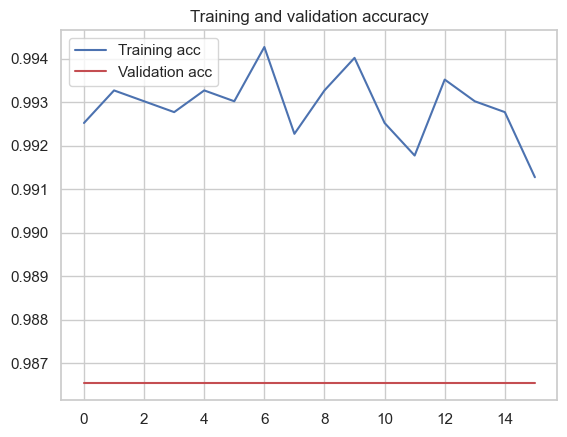

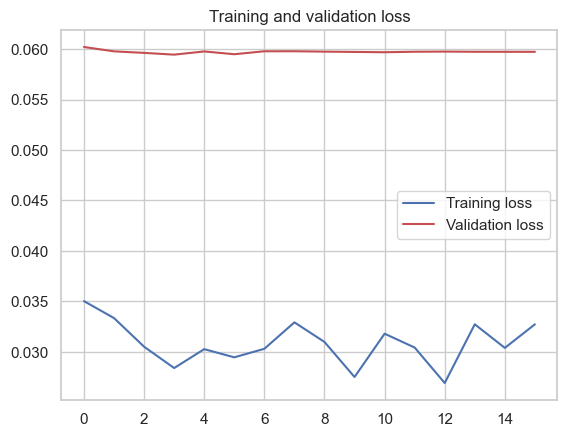

In [226]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [231]:
acc = alt_history.history['accuracy']
val_acc = alt_history.history['val_accuracy']
loss = alt_history.history['loss']
val_loss = alt_history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

array([[1.9524028e-04],
       [1.7570643e-05],
       [7.0286412e-03],
       ...,
       [2.5055646e-03],
       [4.1003921e-05],
       [1.4681324e-04]], dtype=float32)

Testing the metrics of each model

In [232]:
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

y_pred = model.predict([test_x, X_test_features], verbose=1)
threshold = 0.5
y_pred = (y_pred > threshold).astype(int)
print(classification_report(y_test, y_pred, target_names = ["Ham", "Spam"]))

35/35 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       976
        Spam       0.97      0.93      0.95       139

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [1]:
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

alt_y_pred = alt_model.predict([test_x, X_test_features], verbose=1)
threshold = 0.5
alt_y_pred = (alt_y_pred > threshold).astype(int)
print(classification_report(y_test, alt_y_pred, target_names = ["Ham", "Spam"]))

KeyboardInterrupt: 

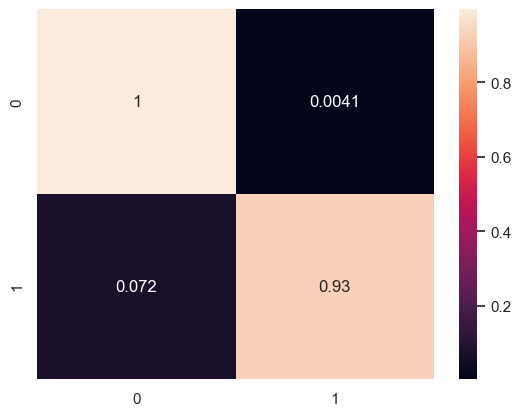

In [238]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True)
plt.show()

In [ ]:
conf_mat = confusion_matrix(y_test, alt_y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True)
plt.show()

DRAW ROC CURVE